# World Series Baseball Predictor
Amazing bookmarked and forked git repo sources.

Key is make features, with a key feature being the Elo Score. The Random Forest is a natural sampler. Also try Logistic Regression. Train it on each world series bracket. Then predict some. Many more data points then if you use the whole bracket vs. just world series winner vs. not. Higher dimensional data, much more info now. 

Otherwise, one of the posts had the bright idea to Monte Carlo the outcomes and take the mode of the WS winner root node to see whose most likely to win. Or something like that. The Monte Carlo could be very powerful, to simulate the models over and over again, calculating probabilities at each step of the way for each realization. 

Need to see precisely how Elo works to determine if Monte Carlo is the best route - are win probabilities on an absolute scale or do they always depend on the opponent? Likely the latter. Two teams ranked 95%, when playing each other, will win only 50% of the time. 

### Elo
Probably best to initialize all teams to the same value. 162 games it should be plenty to distinguish the teams. You should make a **separate** script for calculating the elo scores for all teams for all years (since we have the data the rankings should be fixed), and then all you have to do is just load the elo scores.

### Retrosheet  
Data for elo = http://www.retrosheet.org/gamelogs/index.html  
Fields for data = http://www.retrosheet.org/gamelogs/glfields.txt  

## To do
Fit the right K_elo factors to real data? Do some machine learning for those. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as ss
%matplotlib inline

Elo ranking code

In [2]:
def calculate_elo_rank(winner_rank, loser_rank, k, penalize_loser=True):
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1)/400.
    odds = 1./(1 + pow(10, exp))
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    if penalize_loser:
        new_rank_diff = new_winner_rank - winner_rank
        new_loser_rank = loser_rank - new_rank_diff
    else:
        new_loser_rank = loser_rank
    if new_loser_rank < 1:
        new_loser_rank = 1
    return (new_winner_rank, new_loser_rank)

#from retrosheet
def get_gamelog(year):
    cols = ["Date","Team Away","Away Gm. No.","Team Home","Home Gm. No.","Team Away Score","Team Home Score"]
    GL = pd.read_csv("retrosheet_GL/GL"+str(year)+".TXT",usecols=[0,3,5,6,8,9,10],names=cols)
    awaywin = GL["Team Away Score"] > GL["Team Home Score"]
    homewin = -awaywin
    GL.loc[awaywin,"Winning Team"] = GL["Team Away"]
    GL.loc[awaywin,"Losing Team"] = GL["Team Home"]
    GL.loc[homewin,"Winning Team"] = GL["Team Home"]
    GL.loc[homewin,"Losing Team"] = GL["Team Away"]
    return GL

#Super fast with numpy arrays but dreadfully slow with Pandas DataFrames! 
def calc_season_elo(year,K_i,K_f):
    GL = get_gamelog(year)
    N = len(GL["Team Home"].unique())
    Team, Elo, wins = GL["Team Home"].unique().tolist(), 1500*np.ones(N), np.zeros(N)
    K_step = (K_f - K_i)/162.  #impact factor - games at end of season mean more for momentum and such
    
    for row in GL.itertuples():
        index_w = Team.index(row[8])
        index_l = Team.index(row[9])
        Elo[index_w], Elo[index_l] = calculate_elo_rank(Elo[index_w], Elo[index_l], K_i+row[3]*K_step)
        wins[index_w] += 1
    Data = zip(Team,Elo,wins)
    np.savetxt("retrosheet_GL/ELO"+str(year)+".TXT",Data,delimiter=",",fmt="%s")
    return Data

def get_season_elo(year,K_elo_i,K_elo_f):
    try:
        Data = np.genfromtxt("retrosheet_GL/ELO"+str(year)+".TXT",delimiter=",",dtype=None)
        return Data
    except:
        print "couldn't find Elo data for %d, calculating now."%year
        return calc_season_elo(year,K_elo_i,K_elo_f)

## Feature 1 - Monte Carlo the playoffs
Here we set up the playoff bracket for each year and Monte Carlo the playoffs X times. There's an option to have Elo's during the playoffs, as well as a linear gradient K factor to give more weight to later games in the season. Outputs the probability of each team in winning the WS, calculated as the number of times they win the WS divided by the total number of attempts.

In [3]:
#current
def get_winner(team1, elo_1, team2, elo_2, series, K):
    P_1 = 1./(1 + pow(10,(elo_2 - elo_1) / 400.))
    if (series == "ALWC") | (series == "NLWC"):
        w_req = 1
    elif (series == "ALDS1") | (series == "ALDS2") | (series == "NLDS1") | (series == "NLDS2"):
        w_req = 3
    else:
        w_req = 4
    w_1 = 0
    w_2 = 0
    while (w_1 < w_req) & (w_2 < w_req):
        ran = np.random.uniform()
        if ran <= P_1:
            w_1 += 1
        else:
            w_2 += 1
    if w_1 == w_req:
        elo_1, elo_2 = calculate_elo_rank(elo_1, elo_2, K)
        return team1, elo_1
    else:
        elo_2, elo_1 = calculate_elo_rank(elo_2, elo_1, K)
        return team2, elo_2

def get_bracket(data,year,K_elo):  #1994 no WS, 1995-1997 is really weird seeding. Gonna be super annoying...
    Team, Elo, wins = zip(*data)
    teams = pd.read_csv("csv/team.csv")
    teams = teams.loc[(teams["year"]==year)]
    teams = teams.loc[(teams["div_win"]=="Y")|(team["wc_win"]=="Y")]
    
    AL = teams.loc[(teams["league_id"]=="AL")&(teams["rank"]==1)].sort_values("w")
    team_name = AL.loc[:,"team_id_retro"].values.tolist()
    team_div = AL.loc[:,"div_id"].values.tolist()
    team_elo = []
    for t in team_name:
        t_id = Team.index(t)
        team_elo.append(Elo[t_id])
    if year > 1997:
        WCAL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="AL")].sort_values("w",ascending=False)
        if year >= 2012:
            WCALteams = WCAL.loc[:,"team_id_retro"].values[0:2]
            t1 = Team.index(WCALteams[0])
            t2 = Team.index(WCALteams[1])
            team_name.insert(0,Team[t1])
            team_elo.insert(0,Elo[t1])
            team_name.insert(0,Team[t2])
            team_elo.insert(0,Elo[t2])
        else:
            if WCAL.loc[:,"div_id"].values[0] == team_div[-1]: #stupid 1998-2011 WC rules
                team_name[-2], team_name[-1] = team_name[-1], team_name[-2]
                team_elo[-2], team_elo[-1] = team_elo[-1], team_elo[-2]
            t1 = Team.index(WCAL.loc[:,"team_id_retro"].values[0])
            team_name.append(Team[t1])
            team_elo.append(Elo[t1])

    NL = teams.loc[(teams["league_id"]=="NL")&(teams["rank"]==1)].sort_values("w")
    dummy = NL.loc[:,"team_id_retro"].values.tolist()
    team_div = NL.loc[:,"div_id"].values.tolist()
    for t in dummy:
        t_id = Team.index(t)
        team_name.append(t)
        team_elo.append(Elo[t_id])
    if (year >= 1995)&(year <= 1997): #too hard to make rules for, just hardcode AL/NL teams together
        team_div = [['SEA','NYA','CLE','BOS','ATL','COL','CIN','LAN'],
                    ['NYA','TEX','BAL','CLE','ATL','LAN','SDN','SLN'],
                    ['CLE','NYA','BAL','SEA','ATL','HOU','SFN','FLO']]
        team_name = team_div[year-1995]
        team_elo = []
        for t in team_name:
            team_elo.append(Elo[Team.index(t)])
    elif year > 1997:
        WCNL = teams.loc[(teams["rank"]>1)&(teams["league_id"]=="NL")].sort_values("w",ascending=False)
        if year >= 2012:
            WCNLteams = WCNL.loc[:,"team_id_retro"].values[0:2]
            t1 = Team.index(WCNLteams[0])
            t2 = Team.index(WCNLteams[1])
            team_name.insert(2,Team[t1])
            team_elo.insert(2,Elo[t1])
            team_name.insert(2,Team[t2])
            team_elo.insert(2,Elo[t2])
        else:
            if WCNL.loc[:,"div_id"].values[0] == team_div[-1]: #stupid 1998-2011 WC rules
                team_name[-2], team_name[-1] = team_name[-1], team_name[-2]
                team_elo[-2], team_elo[-1] = team_elo[-1], team_elo[-2]
            t1 = Team.index(WCNL.loc[:,"team_id_retro"].values[0])
            team_name.append(Team[t1])
            team_elo.append(Elo[t1])
    return team_name, team_elo

def simulate_playoffs(team_name, team_elo, K_elo, year):
    series = ["ALCS","NLCS","WS"]
    if year > 1994:
        series = ["ALDS2","ALDS1","NLDS2","NLDS1"] + series
    if year >= 2012:
        series = ["ALWC","NLWC"] + series 
    for i,s in enumerate(series):
        winner_team, winner_elo = get_winner(team_name[2*i],team_elo[2*i],team_name[2*i+1],team_elo[2*i+1],s,K_elo)
        if s == "ALWC":
            team_name.insert(7,winner_team)
            team_elo.insert(7,winner_elo)           
        else:
            team_name.append(winner_team)
            team_elo.append(winner_elo)
    return team_name[-1]

def MC_playoffs(year, n_throws, K_elo_season_i, K_elo_season_f, K_elo_playoffs):
    ws_winners = []
    data = get_season_elo(year, K_elo_season_i, K_elo_season_f) 
    teams, elo = get_bracket(data, year, K_elo_playoffs)
    for i in xrange(0,n_throws):
        ws_winners.append(simulate_playoffs(teams[:], elo[:], K_elo_playoffs, year))
    return ws_winners

## Feature 2 - various W/L statistics about the regular season
Maybe a team makes the playoffs, but how are the wins distributed in their season:
* How did they do in the last X games of the season (half of the playoffs is about momentum).
* Maybe they are very streaky, e.g. 15 game winning streak followed by a 15 game losing streak.

In [4]:
def calc_win_stats(year,n_final_games):
    GL = get_gamelog(year)
    Team = GL["Team Home"].unique().tolist()
    EOS_Wins = np.zeros(len(Team))      #end of season wins
    EOS_Runs = np.zeros((len(Team),2))  #end of season wins
    game_no = 162 - n_final_games
    
    WL_dict = {}
    for t in Team:
        WL_dict[t] = []  
    #Get number of wins in last X games of season, prep W/L streaks
    for row in GL.itertuples():
        WL_dict[row[8]].append("W")
        WL_dict[row[9]].append("L")
        
        if (row[3] >= game_no) | (row[5] >= game_no):
            EOS_Runs[Team.index(row[2]),0] += row[6]
            EOS_Runs[Team.index(row[2]),1] += row[7]
            EOS_Runs[Team.index(row[4]),0] += row[7]
            EOS_Runs[Team.index(row[4]),1] += row[6]
            if (row[8] == row[2]) & (row[3] >=game_no):
                EOS_Wins[Team.index(row[8])] += 1
            elif (row[8] == row[4]) & (row[5] >=game_no):
                EOS_Wins[Team.index(row[8])] += 1
                
    #W/L streak arrays post-processing
    WL = ["W","L"]
    for t in Team:
        while len(WL_dict[t]) < 162:  #I guess there are a few missing values?
            WL_dict[t].insert(0,WL[np.random.randint(0,2)])
        
    #get W/L streaks
    Win_range = 15
    streak_dist = {}
    for team, WLrow in WL_dict.iteritems():
        dist = np.empty(0)     #Each is a bin from -win_range to +win_range, excl. 0 
        WL_prev = WLrow[0]
        streak = 0
        for val in WLrow:
            if val == WL_prev:
                streak += 1
            else:
                index = -1 if WL_prev == "L" else 1
                dist = np.append(dist, streak*index)
                WL_prev = val
                streak = 1
        index = -1 if WL_prev == "L" else 1
        dist = np.append(dist, streak*index)
        streak_dist[team] = dist
    
    fc = ["team","eos_wins","eos_runs_ratio"]
    return pd.DataFrame(zip(Team,EOS_Wins,EOS_Runs[:,0]/EOS_Runs[:,1]), columns=fc, index=Team), streak_dist

## Feature 3 - Great Managers and All-Star Players

In [5]:
def get_allstars_and_managers(team, year_cutoff):
    allstars = pd.read_csv("csv/all_star.csv")
    allstars = allstars[allstars["year"]>year_cutoff]
    allstars.loc[allstars["team_id"]=="ML4","team_id"] == "MIL"
    allstars.loc[allstars["team_id"]=="LAA","team_id"] == "ANA"

    team["n_allstars"] = 0
    for row in allstars.itertuples():
        team.loc[(team["year"]==row[2])&(team["team_id_retro"]==row[5]),"n_allstars"] += 1
    
    return team

## Prepare Data
It's time to start reading in some data, and preparing our features for the various machine learning algorithms we're going to use.

The cell below contains the key parameters needed to prepare the data.

In [6]:
#parameters
K_elo_season_i = 15
K_elo_season_f = 30
K_elo_playoffs = K_elo_season_f
n_draws = 1000
year_cutoff = 1969  #1969 = beginning of modern MLB era

n_final_games = 25

In [7]:
#load data and pre-process
team = pd.read_csv("csv/team.csv")
team = team[(team["div_win"]=="Y")|(team["wc_win"]=="Y")] #only want playoff teams
team = team[team["year"]>=year_cutoff]                    #1969 = since division series was made
team = team[team["year"]!=1981]
del_columns = ["div_id","name","team_id_lahman45","franchise_id","team_id","team_id_br","ppf","bpf","park",
               "attendance","ghome","g","ab","double","triple","hr","bb","so","sb","cs","hbp","sf","ra","er","era",
              "cg","sho","sv","ipouts","ha","hra","bba","soa","e","dp","fp"]
team.drop(del_columns, axis=1, inplace=True)

#create feature arrays
team["ws_prob"] = 0
team["eos_wins"] = 0
team["eos_runs_ratio"] = 0
team["wl_std"] = 0
team["wl_skew"] = 0

#skipped years
y_skip = [1981,1994]

Get all the stats. This might take a minute.

Other stats to consider:  
* Something about the manager, experience?
* Number of all stars - sometimes playoffs boil down to a few key events from a few key players.

In [8]:
#ws_prob (elo), end of season stats, W/L season streak stats
for y in range(year_cutoff, 2016):
    if y not in y_skip:
        winners = MC_playoffs(y, n_draws, K_elo_season_i, K_elo_season_f, K_elo_playoffs)
        for name, value in Counter(winners).iteritems():
            team.loc[(team["team_id_retro"]==name)&(team["year"]==y),"ws_prob"] = value/float(n_draws)

        final_wins, streaks = calc_win_stats(y,n_final_games)
        for row in final_wins.itertuples():
            index = (team["team_id_retro"]==row[1])&(team["year"]==y)
            team.loc[index,"eos_wins"] = row[2]
            team.loc[index,"eos_runs_ratio"] = row[3]
        for keys, values in streaks.iteritems():
            index = (team["team_id_retro"]==keys)&(team["year"]==y)
            team.loc[index,"wl_std"] = np.std(values)
            team.loc[index,"wl_skew"] = ss.skew(values)

#get all stars, manager stats
team = get_allstars_and_managers(team, year_cutoff)

In [9]:
#multi-label classification
team.loc[team["ws_win"] == "Y", "ws_win"] = 1
team.loc[team["ws_win"] == "N", "ws_win"] = 0
team.loc[pd.isnull(team["ws_win"]), "ws_win"] = 0

team.loc[team["lg_win"] == "Y", "lg_win"] = 1
team.loc[team["lg_win"] == "N", "lg_win"] = 0
team.loc[pd.isnull(team["lg_win"]), "lg_win"] = 0

## Onto Machine Learning
Now that we've spent quite some time creating the features we want to use, it's time to input these features and see how our algorithm performs for predicting **who will make it to the WS final**.

### Split Data
Here were going to try splitting the data into train/test, but with the condition that no teams from the same year are ever separated. Might make a difference as far as keeping all the biases of one year together?

In [10]:
Xcolumns = ["ws_prob","eos_wins","eos_runs_ratio","wl_std","wl_skew","n_allstars"]
#ycolumns = ["lg_win","ws_win"]
#y = team[ycolumns].astype(int).values
y = team["lg_win"].astype(int).values
X = team[Xcolumns]

In [11]:
from sklearn.cross_validation import train_test_split,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Perform RF

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
cv_s = StratifiedShuffleSplit(y_train,  n_iter=10 , test_size=0.15, random_state=42)
rfc = RandomForestClassifier(max_features= 'auto' ,n_estimators=50, oob_score=1, class_weight='balanced') 
param_grid = { 
        'n_estimators': [600],
        'max_features': ['sqrt','log2'],
        'min_samples_leaf': [5,10,20]}
CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="roc_auc", param_grid=param_grid, cv=cv_s)
CV_rfc.fit(X_train, y_train);
print("Best Parameters from gridsearch: {%s} with a score of %0.4f" % (CV_rfc.best_params_, CV_rfc.best_score_))

Best Parameters from gridsearch: {{'max_features': 'log2', 'n_estimators': 600, 'min_samples_leaf': 20}} with a score of 0.5748


In [13]:
modelrfc = CV_rfc.best_estimator_

In [14]:
from sklearn import metrics

y_pred = modelrfc.predict_proba(X_test) #probability that team0 wins (what Kaggle calls team 1, and wants for submission)

#test_score = metrics.roc_auc_score(y_test[:,0], y_pred[0][:,1], average="weighted") #area under curve from prediction scores
test_score = metrics.roc_auc_score(y_test, y_pred[:,1], average="weighted")
print("AUC score is {0}".format(test_score))
print("OOB score is {0}".format(modelrfc.oob_score_)) #you may not(?) need test/train split with OOB score!

AUC score is 0.550264550265
OOB score is 0.554112554113


In [15]:
print("Feature\t\tImportance\n")
for i in reversed(np.argsort(modelrfc.feature_importances_)):
    print("%s\t\t%f" % (X.columns[i], modelrfc.feature_importances_[i]))

Feature		Importance

ws_prob		0.256548
wl_std		0.224475
n_allstars		0.154863
eos_runs_ratio		0.150438
wl_skew		0.140583
eos_wins		0.073095


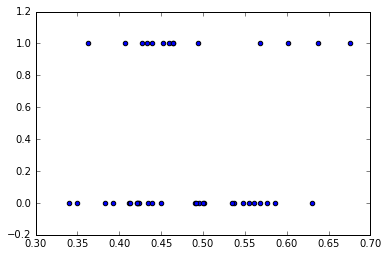

In [16]:
plt.scatter(y_pred[:,1],y_test)

### Perform KNN

In [17]:
#First scale data
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, test_size=0.15, random_state=43)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, weights="distance")
cv_s = StratifiedShuffleSplit(ys_train,  n_iter=10 , test_size=0.2, random_state=42)
param_grid = { 
        'n_neighbors': [5,10,15,20],
        'weights':['distance','uniform']
}
CV_knn = GridSearchCV(n_jobs=-1, estimator=knn, scoring="roc_auc", param_grid=param_grid, cv=cv_s)
CV_knn.fit(Xs_train, ys_train);
print("Best Parameters from gridsearch: {%s} with a score of %0.4f" % (CV_knn.best_params_, CV_knn.best_score_))

Best Parameters from gridsearch: {{'n_neighbors': 20, 'weights': 'uniform'}} with a score of 0.4672


In [19]:
modelknn = CV_knn.best_estimator_

In [20]:
ys_pred = modelknn.predict_proba(Xs_test) #probability that team0 wins (what Kaggle calls team 1, and wants for submission)

test_score_knn = metrics.roc_auc_score(ys_test, ys_pred[:,1], average="weighted")
#test_score = metrics.roc_auc_score(ys_test[:,0], ys_pred[0][:,1], average="weighted") #area under curve from prediction scores
print("AUC score is {0}".format(test_score_knn))

AUC score is 0.490740740741


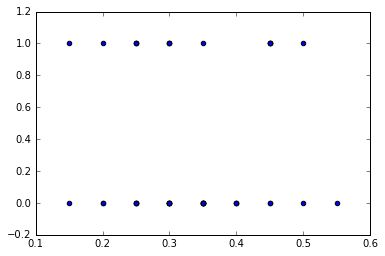

In [21]:
plt.scatter(ys_pred[:,1],ys_test)
#pd.DataFrame([ys_pred[:,1], ys_test]).T

# Notes

### A note about y_pred
So for multilabel classification (like in this case, where I fit for lg_win and cs_win), the predict_proba output is arranged like this:  
http://stackoverflow.com/questions/17017882/scikit-learn-predict-proba-gives-wrong-answers

The model.classes returns:  
[array([0, 1]), array([0, 1])]  
which tells me how the data is arranged (i.e. two output labels, each with binary output 0/1), and the shape of y_pred is:  
(n_choices_per_label, n_samples, n_label)

### OOB score
It is method similar to Cross-Validation, the advantage being it doesn't require a train/test split of the data. After  decision tree X has been trained, a classification error is calculated using the "out of bag" samples, i.e. bootstrapped samples from the original dataset that weren't used to train tree X. Lower OOB score is better.  
Links:  
* http://stackoverflow.com/questions/18541923/what-is-out-of-bag-error-in-random-forests
* Breiman (1996)

### Next step maybe? 
* Maybe add one or two features, but not too many more. Maybe a few from your old attempt. But I think you need to train each series separately maybe? Randomize years, but have conditions where you never separate teams from the same year. It helps include all the distinct noise in each particular year. All teams from the same year have biases and correlations that are related to one another. And so maybe they cancel out a bit? At the very least, Elo scores from similar years probably are easier to compare directly, and are apples to apples. An elo of 1500 from e.g. the 1960s may be an orange to e.g. elo of 1500 from 2006, which is an apple. But can that be done easily?  
* You also need to figure more about the KNN. Why did it have such a high accuracy score and bad AUC score (lower the better, right?)? Did it just fit all the noise? Did the KNN even fit the data properly? Can it recognize multi label? How does it do it?

In [22]:
#Train/test split data, but keep teams from same year together
#test_size = 0.2

#np.random.seed(42)
#years = team["year"].unique()
#rand = np.random.rand(len(years))

#train = team["year"].isin(years[rand>test_size])
#test = team["year"].isin(years[rand<=test_size])
#X_train, y_train = team.loc[train, Xcolumns].values, team.loc[train, "lg_win"].astype(int).values
#X_test, y_test = team.loc[test, Xcolumns].values, team.loc[test, "lg_win"].astype(int).values